<a href="https://colab.research.google.com/github/Rex-Chan99/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas_ta
!pip install numpy==1.23.5
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=45f5c27e404f694091c28bc696f7706b38ade72421f4282d86c37100857ab192
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
scikit-im

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [26]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

import pandas as pd
import pandas_ta as ta
import csv
import numpy as np

btc_data = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')
btc_data.tail(5)

Cloning into 'Bitcoin_prediction'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 82 (delta 25), reused 15 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 4.43 MiB | 19.64 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction


,Date,Price,Open,High,Low,Vol. ('000),Change %\r
4107,1/5/2014,1014.7,924.7,1029.9,911.4,21.37,9.74%\r
4108,1/4/2014,924.7,884.3,932.2,848.3,14.24,4.57%\r
4109,1/3/2014,884.3,856.9,888.2,839.4,9.71,3.19%\r
4110,1/2/2014,856.9,815.9,886.2,810.5,12.81,5.02%\r
4111,1/1/2014,815.9,805.9,829.9,771.0,10.76,1.24%


In [27]:
# Convert the dictionary to a DataFrame
btc_data = pd.DataFrame(btc_data)

# 1. Parse the "Date" column into datetime format
btc_data["Date"] = pd.to_datetime(btc_data["Date"], format="%m/%d/%Y")

# 2. Sort the data by date in ascending order
btc_data.sort_values(by="Date", ascending=True, inplace=True)

#3. Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)

# 4. Remove '%' from "Change %" and convert to numeric
btc_data.rename(columns={"Change %\r": "Change"}, inplace=True)
btc_data["Change"] = btc_data["Change"].str.replace("%", "").str.strip().astype(float)

In [28]:
# Calculate RSI, EMA, SMA, and MACD
btc_data["RSI_6"] = ta.rsi(btc_data["Price"], length=6)  # Relative Strength Index
btc_data["RSI_12"] = ta.rsi(btc_data["Price"], length=12)  # Relative Strength Index
btc_data["EMA_14"] = ta.ema(btc_data["Price"], length=14)  # Exponential Moving Average
btc_data["SMA_14"] = ta.sma(btc_data["Price"], length=14)  # Simple Moving Average

# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

# Calculate MACD --------------------------------------------------------------------------------------
macd = ta.macd(btc_data["Price"], fast=12, slow=26, signal=9)
btc_data["MACD"] = macd["MACD_12_26_9"]
btc_data["MACD_Signal"] = macd["MACDs_12_26_9"]
btc_data["MACD_Hist"] = macd["MACDh_12_26_9"]

# Categorical MACD - Buy (1) and Sell (0) signals
btc_data["C_MACD"] = None  # Default to None (no signal)
btc_data.loc[
    (btc_data["MACD"] > btc_data["MACD_Signal"]) &
    (btc_data["MACD"].shift(1) <= btc_data["MACD_Signal"].shift(1)),
    "C_MACD"] = 1  # Buy signal # Detect Buy Signal (Crossover Up)
btc_data.loc[
    (btc_data["MACD"] <= btc_data["MACD_Signal"]) &
    (btc_data["MACD"].shift(1) > btc_data["MACD_Signal"].shift(1)),
    "C_MACD"] = 0  # Sell signal # Detect Sell Signal (Crossover Down)

# Calculate Bollinger Bands --------------------------------------------------------------------------------------
bbands = ta.bbands(btc_data["Price"], length=20, std=2)
btc_data["BB_Lower"] = bbands["BBL_20_2.0"]  # Lower Band
btc_data["BB_Middle"] = bbands["BBM_20_2.0"]  # Middle Band
btc_data["BB_Upper"] = bbands["BBU_20_2.0"]  # Upper Band
btc_data["BB_Percentage"] = ((btc_data["BB_Upper"] - btc_data["BB_Lower"]) / btc_data["BB_Middle"])

# Initialize C_BB column (default to no signal)
btc_data["C_BB"] = None

# Generate Buy and Sell Signals based on Bollinger Band crossovers
btc_data.loc[
    (btc_data["Price"] < btc_data["BB_Lower"]) & (btc_data["Price"].shift(1) >= btc_data["BB_Lower"].shift(1)),
    "C_BB"] = 1  # Buy signal (Price crosses below Lower Band)

btc_data.loc[
    (btc_data["Price"] > btc_data["BB_Upper"]) & (btc_data["Price"].shift(1) <= btc_data["BB_Upper"].shift(1)),
    "C_BB"] = 0  # Sell signal (Price crosses above Upper Band)

# Calculate ATR --------------------------------------------------------------------------------------
btc_data["ATR"] = ta.atr(btc_data["High"], btc_data["Low"], btc_data["Price"], length=14)

# Set Stop-Loss Levels (Example with Long Trade)
atr_multiplier = 2
btc_data["Stop_Loss_Long"] = btc_data["Price"] - (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Buy (Long) Trade
btc_data["Stop_Loss_Short"] = btc_data["Price"] + (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Sell (Short) Trade

# Calculate VWAP --------------------------------------------------------------------------------------
btc_data.set_index("Date", inplace=True) # Set the "Date" column as the index
btc_data["VWAP"] = ta.vwap(btc_data["High"], btc_data["Low"], btc_data["Price"], btc_data["Volume"])

# Initialize the "C_VWAP" column
btc_data["C_VWAP"] = None
# Generate buy and sell signals based on VWAP crossover
btc_data.loc[
    (btc_data["Price"] > btc_data["VWAP"]) & (btc_data["Price"].shift(1) <= btc_data["VWAP"].shift(1)),
    "C_VWAP"] = 1  # Buy signal (Price crosses above VWAP)

btc_data.loc[
    (btc_data["Price"] < btc_data["VWAP"]) & (btc_data["Price"].shift(1) >= btc_data["VWAP"].shift(1)),
    "C_VWAP"] = 0  # Sell signal (Price crosses below VWAP)
btc_data = btc_data.reset_index() #reset index

# Display the first few rows of the data with calculated indicators
btc_data.tail(20)

,Date,Price,Open,High,Low,Vol. ('000),Change,Volume,RSI_6,RSI_12,...,BB_Lower,BB_Middle,BB_Upper,BB_Percentage,C_BB,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,C_VWAP
4092,2025-03-17,84019.1,82580.3,84729.2,82525.0,58.04,1.74,58.04,49.902637,45.098575,...,78135.646812,85114.295,92092.943188,0.163983,None,4302.423779,75414.252443,92623.947557,83757.766667,1
4093,2025-03-18,82719.1,84019.1,84019.1,81171.3,58.17,-1.55,58.17,44.394082,42.845898,...,77992.343242,85039.615,92086.886758,0.165741,None,4198.522080,74322.055840,91116.144160,82636.500000,None
4094,2025-03-19,86841.0,82719.1,86990.6,82557.5,84.61,4.98,84.61,60.840909,51.265892,...,78057.444745,85145.935,92234.425255,0.166502,None,4215.277646,78410.444708,95271.555292,85463.033333,None
4095,2025-03-20,84208.1,86841.3,87419.0,83656.1,69.86,-3.03,69.86,49.596634,46.493041,...,78044.654434,85137.280,92229.905566,0.166616,None,4182.964957,75842.170086,92574.029914,85094.400000,0
4096,2025-03-21,84073.3,84208.7,84831.0,83215.9,42.8,-0.16,42.80,49.039806,46.252534,...,77943.901437,85037.365,92130.828563,0.166832,None,3999.546031,76074.207937,92072.392063,84040.066667,1
4097,2025-03-22,83840.5,84076.6,84526.3,83688.2,20.84,-0.28,20.84,47.924733,45.806111,...,78816.417377,84516.135,90215.852623,0.134879,None,3773.728458,76293.043085,91387.956915,84018.333333,0
4098,2025-03-23,86077.4,83840.2,86082.0,83812.7,31.13,2.67,31.13,58.741800,50.785288,...,78817.377772,84509.520,90201.662228,0.134710,None,3666.269282,78744.861436,93409.938564,85324.033333,1
4099,2025-03-24,87490.0,86076.1,88740.2,85541.6,95.71,1.64,95.71,64.352990,53.714898,...,78806.103724,84520.705,90235.306276,0.135224,None,3632.864333,80224.271333,94755.728667,87257.266667,None
4100,2025-03-25,87404.0,87495.3,88523.3,86328.5,75.24,-0.10,75.24,63.719878,53.503372,...,79183.795264,84360.320,89536.844736,0.122724,None,3530.145452,80343.709095,94464.290905,87418.600000,0
4101,2025-03-26,86912.0,87349.8,88276.7,85866.4,62.04,-0.56,62.04,59.688531,52.219975,...,79540.198132,84209.375,88878.551868,0.110894,None,3450.156492,80011.687017,93812.312983,87018.366667,None


In [30]:
# Day of the week (0=Monday, 6=Sunday)
btc_data["Day_of_Week"] = btc_data["Date"].dt.dayofweek

# Week of the year
btc_data["Week_of_Year"] = btc_data["Date"].dt.isocalendar().week

# Month of the year
btc_data["Month"] = btc_data["Date"].dt.month

# Quarter of the year
btc_data["Quarter"] = btc_data["Date"].dt.quarter

# Year
btc_data["Year"] = btc_data["Date"].dt.year
btc_data.tail()

,Date,Price,Open,High,Low,Vol. ('000),Change,Volume,RSI_6,RSI_12,...,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,C_VWAP,Day_of_Week,Week_of_Year,Month,Quarter,Year
4107,2025-04-01,85164.2,82548.6,85506.2,82435.8,66.72,3.17,66.72,55.110436,49.849551,...,3192.233959,78779.732082,91548.667918,84368.733333,1,1,14,4,2,2025
4108,2025-04-02,82525.0,85166.0,88377.3,82358.9,104.05,-3.10,104.05,39.571214,43.207951,...,3394.102962,75736.794076,89313.205924,84420.400000,0,2,14,4,2,2025
4109,2025-04-03,83159.4,82522.6,83908.9,81313.8,83.15,0.77,83.15,44.116403,45.125138,...,3337.031322,76485.337357,89833.462643,82794.033333,1,3,14,4,2,2025
4110,2025-04-04,83866.7,83160.2,84704.1,81691.1,91.54,0.85,91.54,49.225834,47.289371,...,3313.886227,77238.927545,90494.472455,83420.633333,None,4,14,4,2,2025
4111,2025-04-05,83552.1,83876.0,84249.3,82384.4,32.71,-0.38,32.71,46.935363,46.401387,...,3210.387211,77131.325578,89972.874422,83395.266667,None,5,14,4,2,2025


In [ ]:
# Support and Resistance Levels
btc_data["Support"] = btc_data["Low"].rolling(window=20).min()  # Lowest low in the past 20 days
btc_data["Resistance"] = btc_data["High"].rolling(window=20).max()  # Highest high in the past 20 days

In [ ]:
# Calculate the percentage price change over the next 7 days (Target Variable for Regression)
btc_data["Pct_Change"] = ((btc_data["Price"].shift(-7) - btc_data["Price"]) / btc_data["Price"]) * 100

In [ ]:
# Drop the original "Vol. ('000)" column
btc_data.drop(columns=["Vol. ('000)"], inplace=True)

# Reset index
btc_data.reset_index(drop=True, inplace=True)

In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4112 non-null   datetime64[ns]
 1   Price          4112 non-null   float64       
 2   Open           4112 non-null   float64       
 3   High           4112 non-null   float64       
 4   Low            4112 non-null   float64       
      4112 non-null   object        
 6   RSI_6          4106 non-null   float64       
 7   RSI_12         4100 non-null   float64       
 8   EMA_14         4099 non-null   float64       
 9   SMA_14         4099 non-null   float64       
 10  MACD           4087 non-null   float64       
 11  MACD_Signal    4079 non-null   float64       
 12  MACD_Hist      4079 non-null   float64       
 13  BB_Upper       4093 non-null   float64       
 14  BB_Middle      4093 non-null   float64       
 15  BB_Lower       4093 non-null   floa

In [ ]:
btc_data.head()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,Volume,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change
0,2014-01-01,815.9,805.9,829.9,771.0,1.24%,NaN,NaN,NaN,NaN,...,10.76,10.76,2,1,1,1,2014,NaN,NaN,15.063120
1,2014-01-02,856.9,815.9,886.2,810.5,5.02%\r,NaN,NaN,NaN,NaN,...,12.81,23.57,3,1,1,1,2014,NaN,NaN,9.347649
2,2014-01-03,884.3,856.9,888.2,839.4,3.19%\r,NaN,NaN,NaN,NaN,...,9.71,33.28,4,1,1,1,2014,NaN,NaN,8.311659
3,2014-01-04,924.7,884.3,932.2,848.3,4.57%\r,NaN,NaN,NaN,NaN,...,14.24,47.52,5,1,1,1,2014,NaN,NaN,8.716340
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74%\r,NaN,NaN,NaN,NaN,...,21.37,68.89,6,1,1,1,2014,NaN,NaN,-7.381492


In [ ]:
btc_data.tail()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,Volume,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change
4107,2025-04-01,85164.2,82548.6,85506.2,82435.8,3.17%\r,55.110436,49.849551,84611.618769,85086.800000,...,66.72,-2.066536e+09,1,14,4,2,2025,79954.9,88740.2,NaN
4108,2025-04-02,82525.0,85166.0,88377.3,82358.9,-3.10%\r,39.571214,43.207951,84333.402933,84778.514286,...,104.05,-2.066536e+09,2,14,4,2,2025,80833.2,88740.2,NaN
4109,2025-04-03,83159.4,82522.6,83908.9,81313.8,0.77%\r,44.116403,45.125138,84176.869208,84703.607143,...,83.15,-2.066536e+09,3,14,4,2,2025,81171.3,88740.2,NaN
4110,2025-04-04,83866.7,83160.2,84704.1,81691.1,0.85%\r,49.225834,47.289371,84135.513314,84688.850000,...,91.54,-2.066536e+09,4,14,4,2,2025,81171.3,88740.2,NaN
4111,2025-04-05,83552.1,83876.0,84249.3,82384.4,-0.38%\r,46.935363,46.401387,84057.724872,84668.250000,...,32.71,-2.066536e+09,5,14,4,2,2025,81171.3,88740.2,NaN


In [ ]:
#draw the data from the fear and greed index
fear_and_greed_index = pd.read_csv('fear_and_greed_index.csv')
# rename the date column in fear_and_greed_index to Date
fear_and_greed_index.rename(columns={"date": "Date"}, inplace=True)
# convert the date column to datetime
fear_and_greed_index["Date"] = pd.to_datetime(fear_and_greed_index["Date"], format="%Y-%m-%d")
# dropping the timestamp, value_classification, time_until_update columns
fear_and_greed_index.drop(columns=["timestamp", "value_classification", "time_until_update"], inplace=True)
fear_and_greed_index.head()

,value,Date
0,34,2025-04-06
1,30,2025-04-05
2,28,2025-04-04
3,25,2025-04-03
4,44,2025-04-02


In [ ]:
# Join the two dataframes on the "Date" column, dropping
btc_data = btc_data.merge(fear_and_greed_index, on="Date", how="left")
btc_data.head()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change,value
0,2014-01-01,815.9,805.9,829.9,771.0,1.24%,NaN,NaN,NaN,NaN,...,10.76,2,1,1,1,2014,NaN,NaN,15.063120,NaN
1,2014-01-02,856.9,815.9,886.2,810.5,5.02%\r,NaN,NaN,NaN,NaN,...,23.57,3,1,1,1,2014,NaN,NaN,9.347649,NaN
2,2014-01-03,884.3,856.9,888.2,839.4,3.19%\r,NaN,NaN,NaN,NaN,...,33.28,4,1,1,1,2014,NaN,NaN,8.311659,NaN
3,2014-01-04,924.7,884.3,932.2,848.3,4.57%\r,NaN,NaN,NaN,NaN,...,47.52,5,1,1,1,2014,NaN,NaN,8.716340,NaN
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74%\r,NaN,NaN,NaN,NaN,...,68.89,6,1,1,1,2014,NaN,NaN,-7.381492,NaN


In [ ]:
# rename the value column to Fear_and_Greed_Index
btc_data.rename(columns={"value": "Fear_and_Greed_Index"}, inplace=True)
# normalize the Fear_and_Greed_Index column
btc_data["Fear_and_Greed_Index"] = (btc_data["Fear_and_Greed_Index"] - btc_data["Fear_and_Greed_Index"].min()) / (btc_data["Fear_and_Greed_Index"].max() - btc_data["Fear_and_Greed_Index"].min())
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
# Add two columns for extreme fear and extreme greed
btc_data["Extreme_Fear"] = np.where(btc_data["Fear_and_Greed_Index"] < 0.2, 1, 0)
btc_data["Extreme_Greed"] = np.where(btc_data["Fear_and_Greed_Index"] > 0.8, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
# Use 70 in RSI to classify overbought and 30 to classify oversold
btc_data["RSI_12_Overbought"] = np.where(btc_data["RSI_12"] > 70, 1, 0)
btc_data["RSI_12_Oversold"] = np.where(btc_data["RSI_12"] < 30, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
# Adding RSI_6 greater than RSI_12 to show bullish divergence and conversely
btc_data["RSI_Bullish_Divergence"] = np.where(btc_data["RSI_6"] > btc_data["RSI_12"], 1, 0)
btc_data["RSI_Bearish_Divergence"] = np.where(btc_data["RSI_6"] < btc_data["RSI_12"], 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


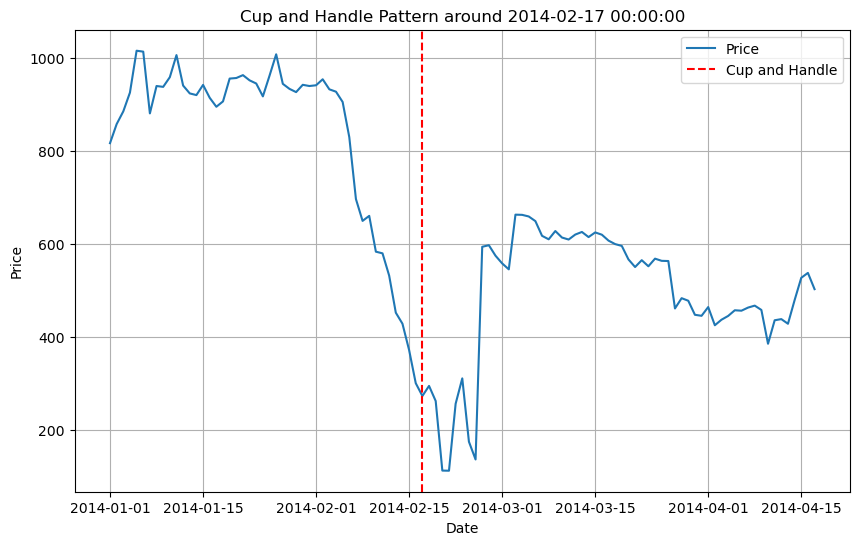

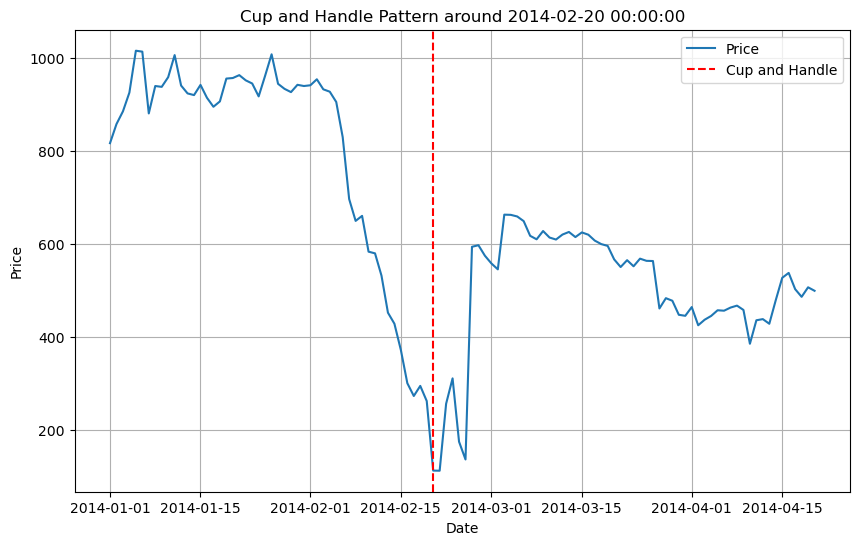

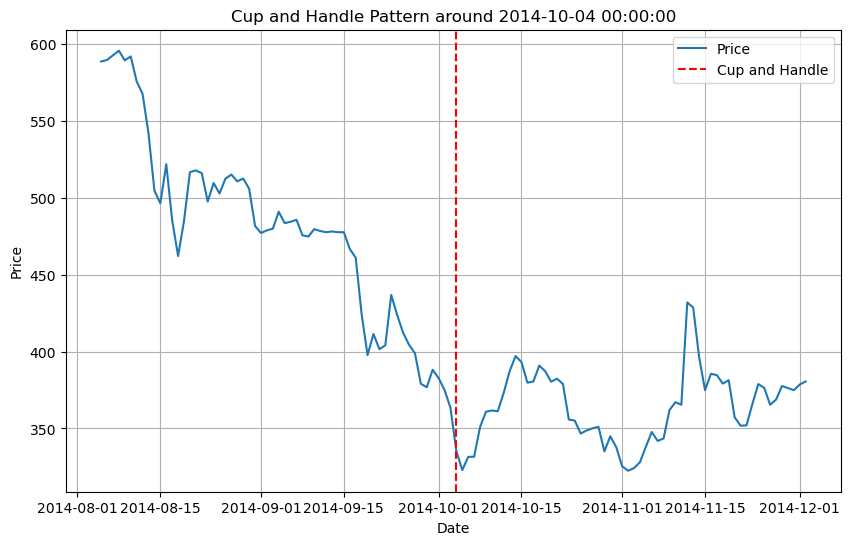

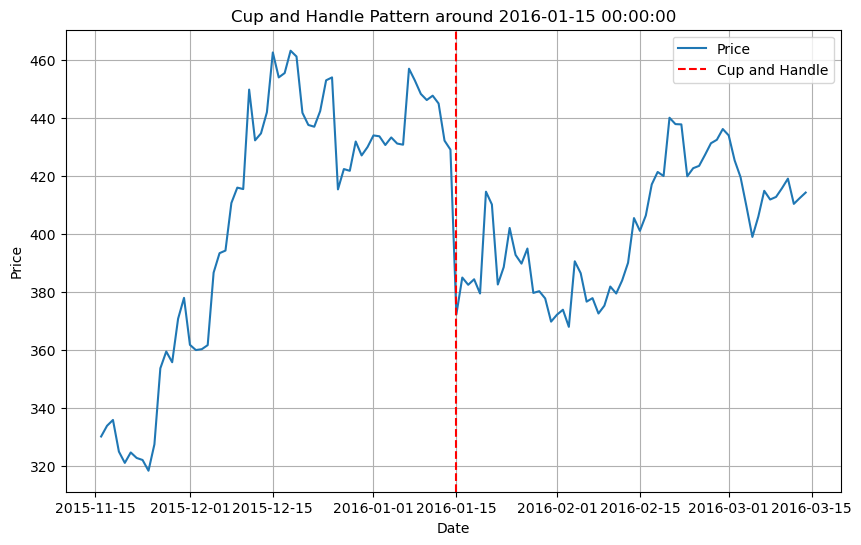

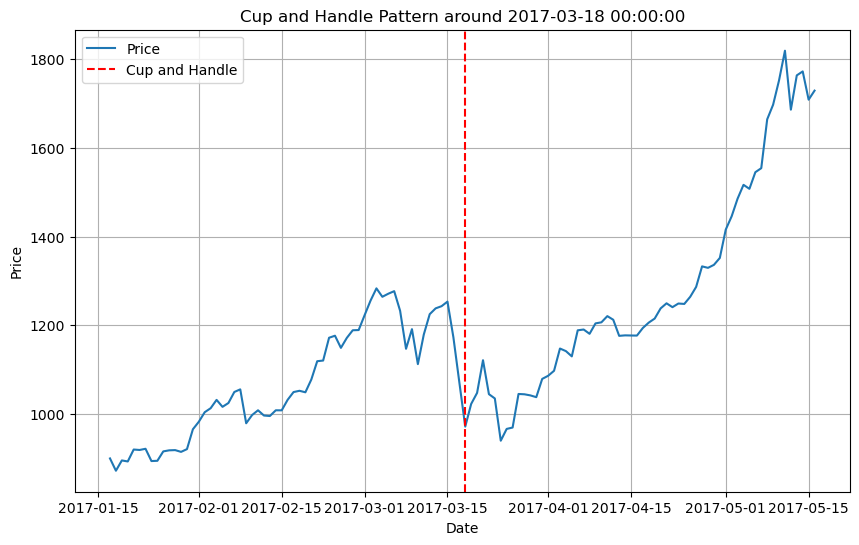

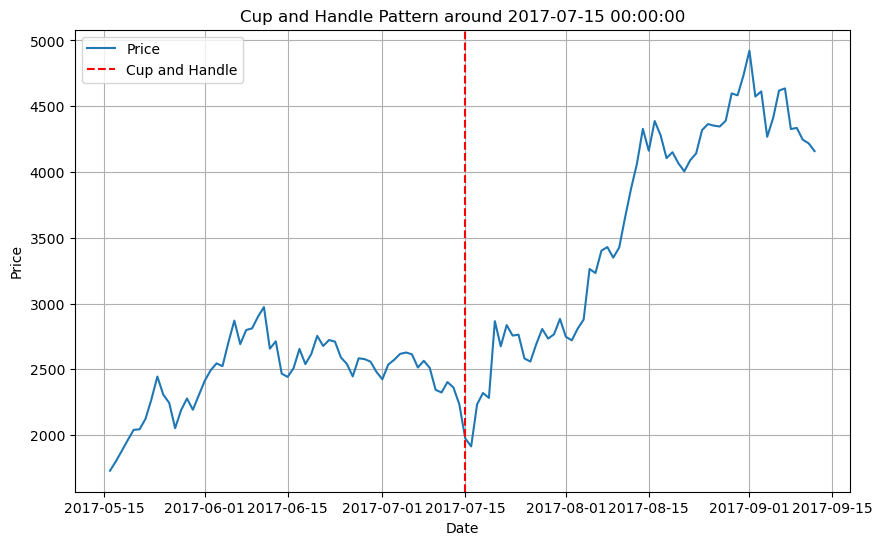

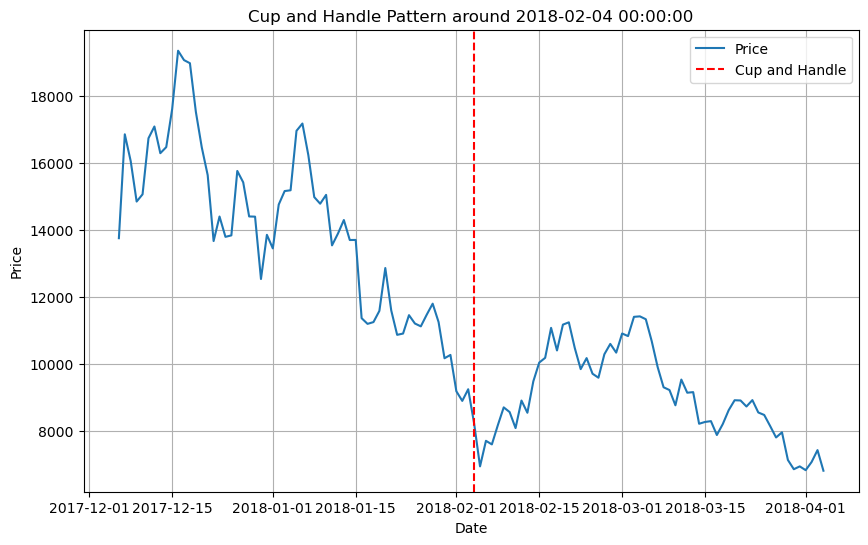

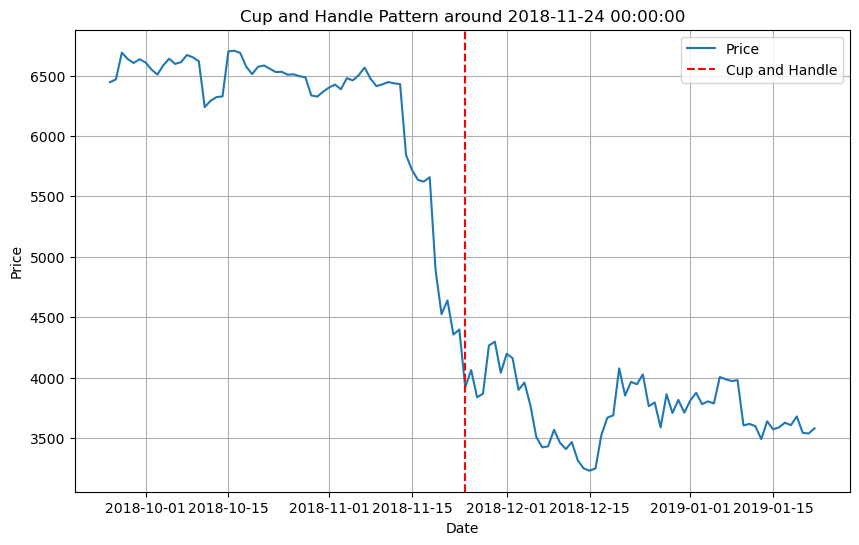

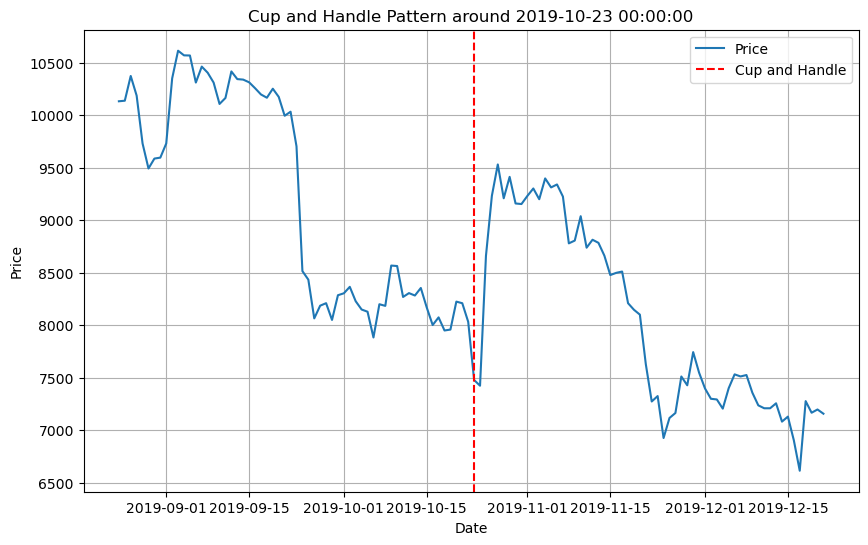

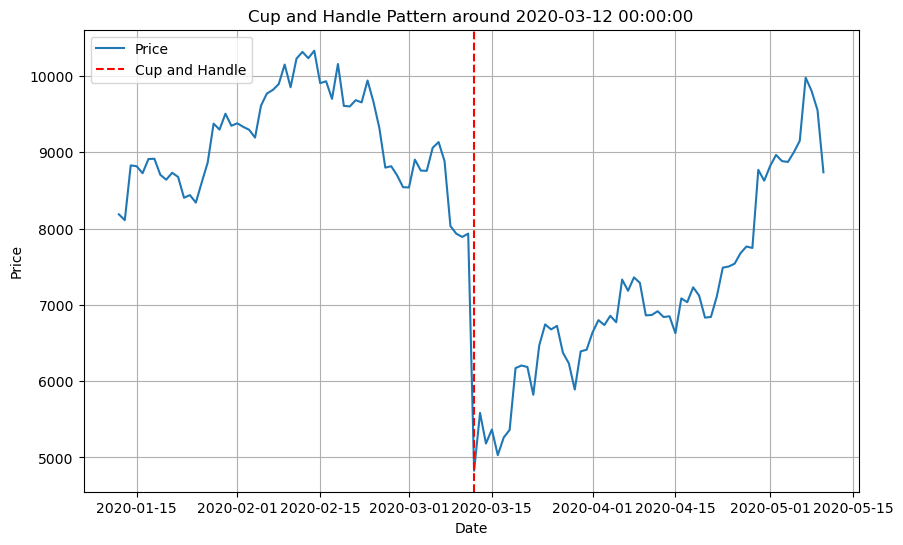

In [ ]:
#Define the cup and handle pattern in the price data
def cup_and_handle_pattern(data):
    # Initialize the pattern column
    data["Cup_and_Handle"] = 0

    # Loop through the data to identify if there is a cup pattern first, the cup pattern is defined as a U shape in a perioud from 7 dayas to 30 days, 5% error is allowed.
    for i in range(30, len(data) - 7):
        # Check if the current price is lower than the previous 30 days
        if data["Price"][i] < data["Price"][i - 30:i].min() * 0.95:
            # Check if the next 7 days are higher than the current price
            if data["Price"][i + 1:i + 8].max() > data["Price"][i] * 1.05:
                # Check if the next 7 days are having a downtrend with the price around 50% of the cup height, cup height is defined as the difference between the current price and the minimum price in the last 30 days
                cup_height = data["Price"][i] - data["Price"][i - 30:i].min()
                if data["Price"][i + 1:i + 8].min() < data["Price"][i] - cup_height * 0.5:
                    # Check if the next 7 days are higher than the current price
                    if data["Price"][i + 8:i + 15].max() > data["Price"][i] * 1.05:
                        # Mark as cup and handle pattern
                        data.at[i, "Cup_and_Handle"] = 1
    return data

# Apply the function to the data
btc_data = cup_and_handle_pattern(btc_data)
# Plot the first ten cup and handle patterns with time period 60 days before and after
import matplotlib.pyplot as plt

# Find the indices of the first ten cup and handle patterns
cup_and_handle_indices = btc_data[btc_data["Cup_and_Handle"] == 1].index[:10]

# Plot each pattern
for idx in cup_and_handle_indices:
    start_idx = max(0, idx - 60)  # Ensure we don't go out of bounds
    end_idx = min(len(btc_data), idx + 60)
    pattern_data = btc_data.iloc[start_idx:end_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(pattern_data["Date"], pattern_data["Price"], label="Price")
    plt.axvline(x=btc_data.iloc[idx]["Date"], color="red", linestyle="--", label="Cup and Handle")
    plt.title(f"Cup and Handle Pattern around {btc_data.iloc[idx]['Date']}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419
